In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.svm import SVR

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

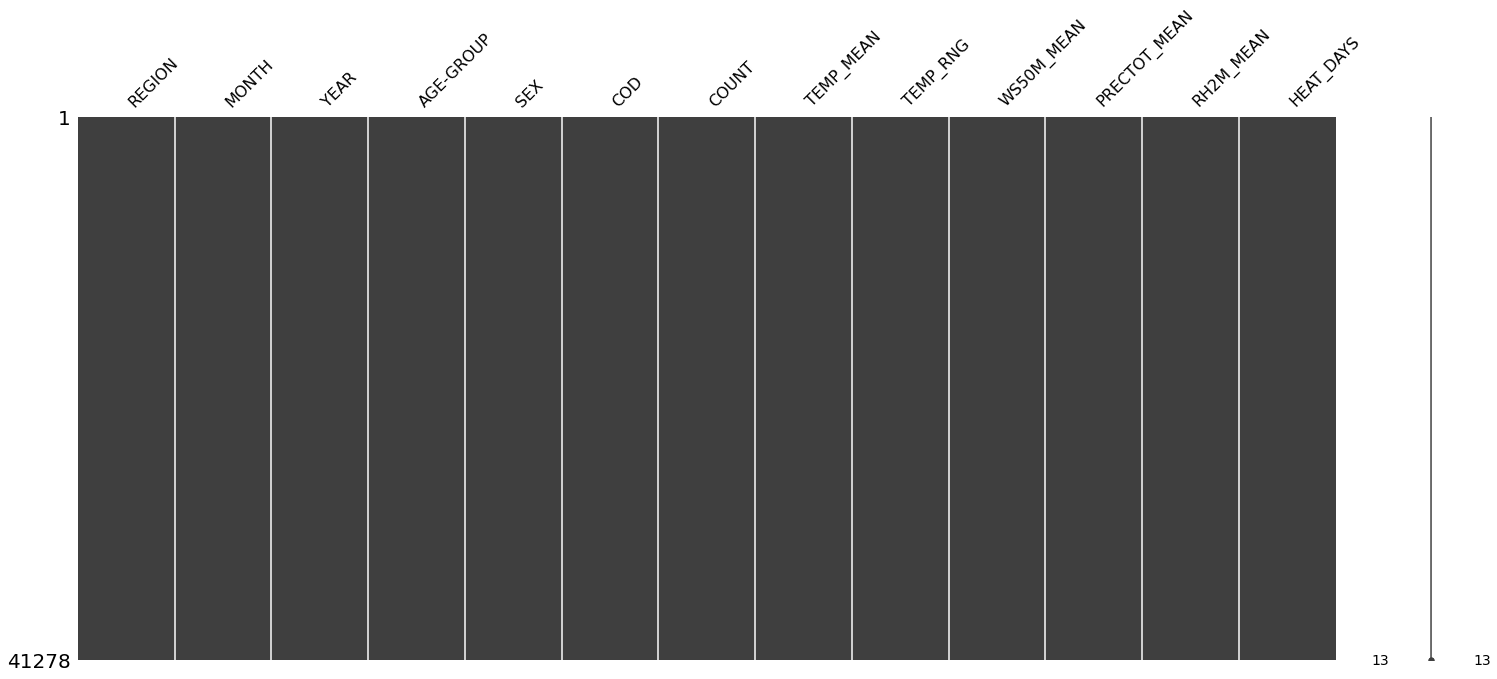

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [5]:
# Train-test split
TEST_SIZE = 0.2
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.to_list()[6:]

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Parameter grids
deg = np.arange(3, 8)
gamma = np.arange(0.005, 0.10, 0.005)
C = np.arange(0.0, 4.0, 0.1)
epsilon = np.arange(0.01, 0.5, 0.05)
params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'regressor__degree': deg, 
         'regressor__gamma': gamma,
         'regressor__C': C,
         'regressor__epsilon': epsilon}

In [8]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('regressor', SVR())
])

In [9]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TEMP_MEAN',
                                                                                'TEMP_RNG',
                                                                                'W

In [10]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__kernel,param_regressor__gamma,param_regressor__epsilon,param_regressor__degree,param_regressor__C,param_preprocessing__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.120250,0.004928,0.026858,0.004222,sigmoid,0.09,0.11,4,2.8,RobustScaler(),"{'regressor__kernel': 'sigmoid', 'regressor__g...",0.119792,0.182163,0.157591,0.127928,0.130977,0.143690,0.023042,3
1,0.116272,0.005063,0.028462,0.004212,sigmoid,0.01,0.46,5,2.9,StandardScaler(),"{'regressor__kernel': 'sigmoid', 'regressor__g...",-0.115516,-0.069848,-0.083170,-0.118256,-0.109872,-0.099332,0.019296,8
2,0.117077,0.003876,0.062605,0.003380,rbf,0.065,0.26,3,3.6,RobustScaler(),"{'regressor__kernel': 'rbf', 'regressor__gamma...",0.138012,0.196238,0.192868,0.158942,0.159240,0.169060,0.022218,2
3,0.120023,0.003667,0.061023,0.000762,rbf,0.03,0.41,4,2.3,StandardScaler(),"{'regressor__kernel': 'rbf', 'regressor__gamma...",0.000535,0.045324,0.042030,0.007654,0.008379,0.020784,0.018920,6
4,0.120208,0.003188,0.026414,0.004313,sigmoid,0.03,0.21,3,0.4,StandardScaler(),"{'regressor__kernel': 'sigmoid', 'regressor__g...",-0.150299,-0.111904,-0.122207,-0.157368,-0.147298,-0.137815,0.017567,9
5,0.093762,0.003142,0.017002,0.003526,poly,0.055,0.46,6,1.9,RobustScaler(),"{'regressor__kernel': 'poly', 'regressor__gamm...",-0.174446,-0.140829,-0.151583,-0.181379,-0.173896,-0.164427,0.015487,10
6,0.121749,0.001234,0.061298,0.000669,rbf,0.045,0.11,5,2,RobustScaler(),"{'regressor__kernel': 'rbf', 'regressor__gamma...",0.037939,0.088135,0.081413,0.051116,0.054080,0.062537,0.019071,5
7,0.121975,0.001740,0.061824,0.000757,rbf,0.015,0.01,7,2.3,RobustScaler(),"{'regressor__kernel': 'rbf', 'regressor__gamma...",-0.044767,0.001221,-0.012487,-0.046532,-0.040447,-0.028602,0.019351,7
8,0.123191,0.000171,0.060700,0.002372,rbf,0.085,0.06,7,3,StandardScaler(),"{'regressor__kernel': 'rbf', 'regressor__gamma...",0.075245,0.120329,0.122869,0.087620,0.095449,0.100303,0.018561,4
9,0.097274,0.004541,0.017146,0.003835,linear,0.025,0.11,4,2,StandardScaler(),"{'regressor__kernel': 'linear', 'regressor__ga...",0.315720,0.402478,0.367063,0.331915,0.334395,0.350314,0.030952,1


In [11]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__kernel': 'linear', 'regressor__gamma': 0.025, 'regressor__epsilon': 0.11, 'regressor__degree': 4, 'regressor__C': 2.0, 'preprocessing__num': StandardScaler()}
Best scores:  0.35031422141306046


In [12]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [13]:
# Test loss
mean_squared_error(y_pred, y_test)

3471.754395926881

In [14]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

3536.716839408698

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


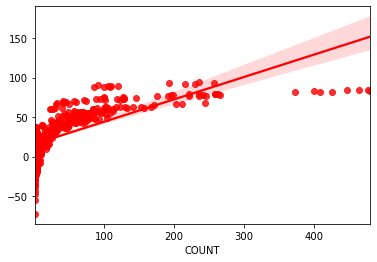

In [15]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [16]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.70154575],
       [0.70154575, 1.        ]])

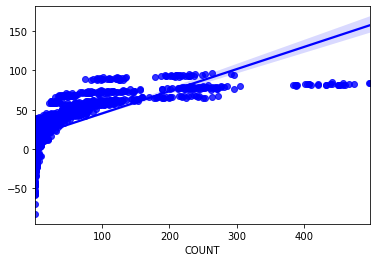

In [17]:
# Training data: y_test, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [18]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.71552724],
       [0.71552724, 1.        ]])